# Example of detrending and geostrophic flow calculation

In [1]:
using DIVAnd
using Dates
using Statistics
using Makie, CairoMakie, GeoMakie
using PhysOcean
using NCDatasets
using DataStructures
using Pkg
include("../config.jl")
# Load a more efficient version of sparse matrix multiplication
include(joinpath(dirname(pathof(DIVAnd)),"override_ssmult.jl"))

In [44]:
Pkg.status()

Status `~/Projects/Diva-Workshops/Project.toml`
  [336ed68f] CSV v0.10.15
⌃ [13f3f980] CairoMakie v0.12.16
  [35d6a980] ColorSchemes v3.27.1
  [34da2185] Compat v4.16.0
  [efc8151c] DIVAnd v2.7.12
  [864edb3b] DataStructures v0.18.20
  [8bb1440f] DelimitedFiles v1.9.1
  [b16dfd50] GRIB v0.4.0 `https://github.com/weech/GRIB.jl#master`
⌃ [2fb1d81b] GeoArrays v0.9.0
  [61d90e0f] GeoJSON v0.8.1
  [db073c08] GeoMakie v0.7.9
  [7073ff75] IJulia v1.26.0
  [a98d9a8b] Interpolations v0.15.1
  [23992714] MAT v0.10.7
⌅ [ee78f7c6] Makie v0.21.16
  [e1d29d7a] Missings v1.2.0
  [85f8d34a] NCDatasets v0.14.6
  [3725be50] PhysOcean v0.6.11 `https://github.com/gher-uliege/PhysOcean.jl.git#master`
  [d330b81b] PyPlot v2.11.5
  [f2b01f46] Roots v2.2.2
  [10745b16] Statistics v1.11.1
  [8d837e6f] TIFFDatasets v0.1.1
  [3d5dd08c] VectorizationBase v0.21.71
  [ade2ca70] Dates v1.11.0
  [37e2e46d] LinearAlgebra v1.11.0
  [56ddb016] Logging v1.11.0
  [44cfe95a] Pkg v1.11.0
  [de0858da] Printf v1.11.0
  [9a3f8

## Bathmetry reading

In [2]:
bathname = gebco08file
download_check(gebco08file, gebco08fileURL)
bathisglobal = true;

[ Info: File already downloaded


## Bathymetry and grid preparation

In [3]:
dx = dy = 0.125

lonr = 27:dx:42
latr = 40:dy:47
depthr = [0., 5., 10, 15., 20, 25., 30, 40, 50, 60, 75, 85, 100, 125, 150, 
    200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000];

sz = (length(lonr),length(latr),length(depthr))

# correlation length in meters (in x, y, and z directions)

epsilon2=1
lenx = [2.5+depthr[k]/1000 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
leny = [1.5+depthr[k]/1000 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
lenz = [5+(depthr[min(k+1,sz[3])]-depthr[max(1,k-1)]) for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]

mask,(pm,pn,po),(xi,yi,zi) = DIVAnd.DIVAnd_rectdom(lonr,latr,depthr)
bx,by,b = DIVAnd.load_bath(bathname,true,lonr,latr)
mask = falses(size(b,1),size(b,2),size(depthr,1))


for j = 1:size(b,2)
    for i = 1:size(b,1)
        for k=1:size(depthr,1)
            mask[i,j,k] = b[i,j] >=zi[i,j,k]
        end
    end
end

Look at topology

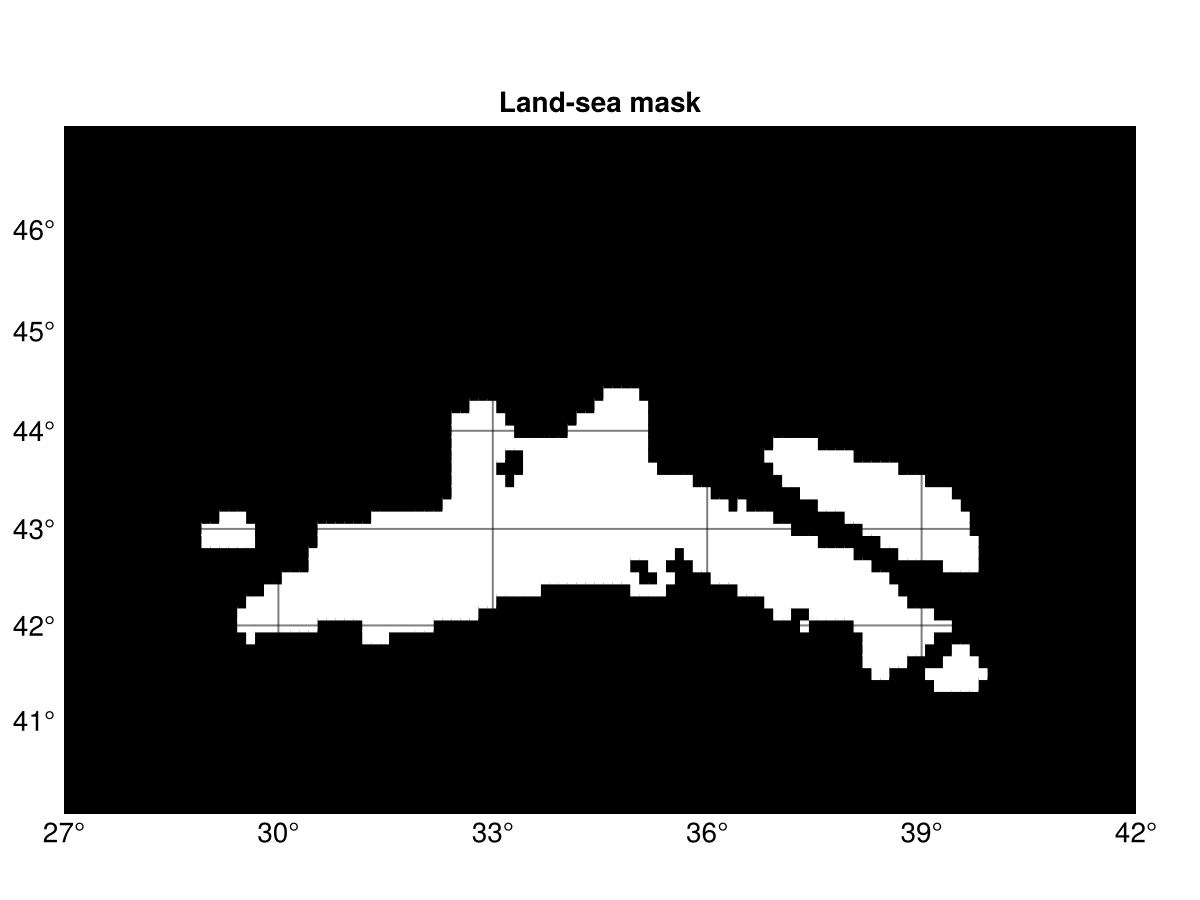

In [4]:
plot_mask(bx, by, mask[:,:,end], xticks=24.:3.:45, yticks=40:1.:47.)

Take out Marmara and Azov sea

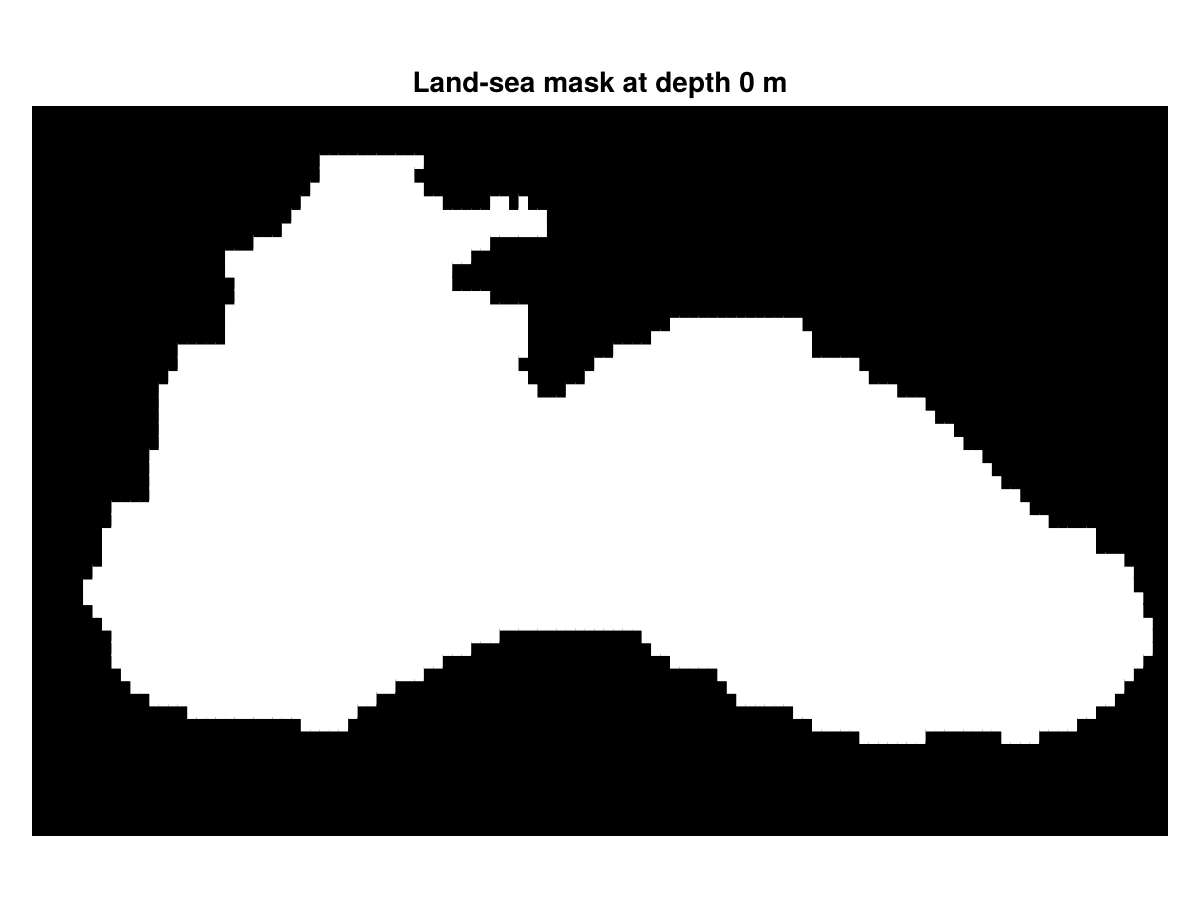

In [5]:
sel1= (xi.>34.75) .& (yi.>45.10)
mask[sel1].=false
sel1= (xi.<29.5) .& (yi.<41.125)
mask[sel1].=false

plot_mask(bx, by, mask[:,:,1], depth=0)

## Load data

In [6]:
datafile = salinitybigfile
download_check(salinitybigfile, salinitybigfileURL)
value,lon,lat,depth,timeval,ids = DIVAnd.loadbigfile(datafile)
@show size(value)

[ Info: File already downloaded
[ Info: Loading data from 'big file' ../data/Salinity.bigfile


size(value) = (139230,)


(139230,)

In [7]:
deepestdata=5500.0
lowestdata=14.0
highestdata=25.0

25.0

### Subset data 
Taking out Marmara and Azov sea

size(value) = (136854,)


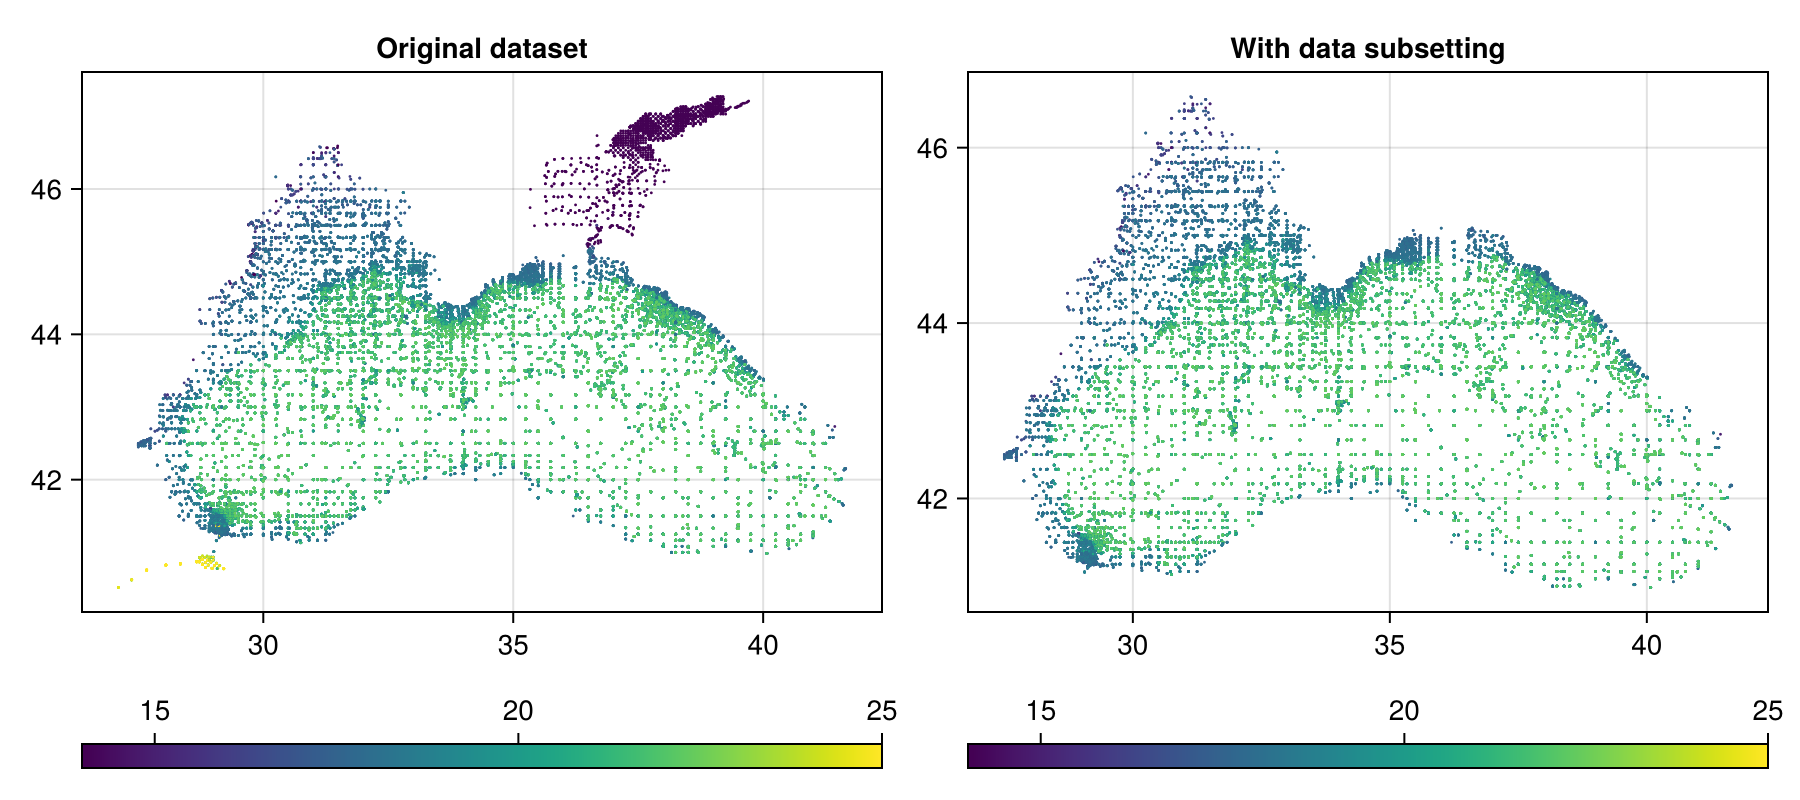

CairoMakie.Screen{IMAGE}


In [8]:
sel=(value.>lowestdata) .& (value.<highestdata).& .~((lon.>34.75) .& (lat.>45.10)) .& 
.~((lon.<29.5) .& (lat.<41.125)) .& (depth.<deepestdata) .& (timeval .> DateTime(Date(1950)))

fig = Figure(size=(900, 400))
ax1 = Axis(fig[1,1], title="Original dataset")
sc1 = scatter!(ax1, lon, lat, color=value, markersize=2, colorrange=[lowestdata,highestdata])
Colorbar(fig[2,1], sc1, vertical=false)

# Perform subsetting
value=value[sel]
lon=lon[sel]
lat=lat[sel]
depth=depth[sel]
timeval=timeval[sel]
ids=ids[sel]

@show(size(value))

ax2 = Axis(fig[1,2], title="With data subsetting")
sc2 = scatter!(ax2, lon, lat, color=value, markersize=2, colorrange=[lowestdata,highestdata])
Colorbar(fig[2,2], sc2, vertical=false)
display(fig)

### Observational error variance inflation factor

In [9]:
rdiag=1.0./DIVAnd.weight_RtimesOne((lon,lat,depth),(0.03,0.03,10));
mean(rdiag)

[ Info: Computing weights using 1 CPU thread(s)


12.07981627420008

### Useful functions to define new coordinates

In [10]:
function dayinyear(x); return Dates.value(Date(x)-Date(Dates.year(x))); end
function daysince1900(x); return Dates.value(Date(x)-Date(Dates.year(DateTime(1900)))); end

daysince1900 (generic function with 1 method)

### Prepare a new analysis space:
- depth, 
- day-in-a-year, 
- time-in-days-from-1900

In [11]:
coordinatesfordetrending=(depth,dayinyear.(timeval),daysince1900.(timeval));
tmin,tmax=extrema(daysince1900.(timeval))
maskt,(pmt,pnt,pot),(xit,yit,zit) = DIVAnd.DIVAnd_rectdom(depthr,0:10:365,tmin:150:tmax);

In [12]:
sz=size(maskt)
lent3 = [15000+10*depthr[i] for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
lent2 = [150+depthr[i]/20 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
lent1 = [5+(depthr[min(i+1,sz[1])]-depthr[max(1,i-1)]) for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]];

Two user functions defining the two scales. One is the trend analysis, the other the normal analysis.

In [13]:
function H1K1(data)
    K1d,s=DIVAnd.DIVAndrun(maskt,(pmt,pnt,pot),(xit,yit,zit),coordinatesfordetrending,data,(lent1,lent2,lent3),epsilon2*rdiag;moddim=[0,365,0]);
    #K1d,s=DIVAndrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K1d,data.-DIVAnd_residual(s,K1d)
end
function H2K2(data)
    K2d,s=DIVAnd.DIVAndrun(mask,(pm,pn,po),(xi,yi,zi),(lon,lat,depth),data,(lenx,leny,lenz),epsilon2*rdiag);
    #K1d,s=DIVAndrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K2d,data.-DIVAnd_residual(s,K2d)
end

H2K2 (generic function with 1 method)

Simple analysis for the trend space

In [14]:
fdet,bidon=H1K1(value .- mean(value));

LoadError: MethodError: no method matching spmatmul(::SparseMatrixCSC{Float64, Int64}, ::SparseMatrixCSC{Float64, Int64}; sortindices::Symbol)
This method may not support any kwargs.

[0mClosest candidates are:
[0m  spmatmul(::Union{SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, SubArray{Tv, 2, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, I}} where I<:(AbstractUnitRange{<:Integer}), LowerTriangular{Tv, <:Union{SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, SubArray{Tv, 2, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, I}} where I<:(AbstractUnitRange{<:Integer})}}, UpperTriangular{Tv, <:Union{SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, SubArray{Tv, 2, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, I}} where I<:(AbstractUnitRange{<:Integer})}}} where {Tv, Ti}, ::Union{SubArray{<:Any, <:Any, <:AbstractSparseArray}, LowerTriangular{Tv, <:Union{SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, SubArray{Tv, 2, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, I}} where I<:(AbstractUnitRange{<:Integer})}} where {Tv, Ti}, UpperTriangular{Tv, <:Union{SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, SubArray{Tv, 2, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, I}} where I<:(AbstractUnitRange{<:Integer})}} where {Tv, Ti}, SparseArrays.AbstractCompressedVector, SparseArrays.AbstractSparseMatrixCSC{Tv, Ti} where {Tv, Ti}})[91m got unsupported keyword argument "sortindices"[39m
[0m[90m   @[39m [32mSparseArrays[39m [90m~/.julia/juliaup/julia-1.11.2+0.x64.linux.gnu/share/julia/stdlib/v1.11/SparseArrays/src/[39m[90m[4mlinalg.jl:215[24m[39m


In [15]:
pcolor(yit[1,:,:],zit[1,:,:],mean(value)+fdet[1,:,:]),colorbar()
figure()
scatter(coordinatesfordetrending[2],coordinatesfordetrending[3],s=2,c=value,vmin=17,vmax=18.4);colorbar()

LoadError: UndefVarError: `pcolor` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Simple surface analysis

In [45]:
fsur,bidon=H2K2(value.-mean(value))
fsurori=fsur;

figure()
pcolor(xi[:,:,1],yi[:,:,1],mean(value)+fsur[:,:,1]),colorbar()
figure()
scatter(lon,lat,s=2,c=value,vmin=17,vmax=18.4);colorbar()

LoadError: MethodError: no method matching spmatmul(::SparseMatrixCSC{Float64, Int64}, ::SparseMatrixCSC{Float64, Int64}; sortindices::Symbol)
This method may not support any kwargs.

[0mClosest candidates are:
[0m  spmatmul(::Union{SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, SubArray{Tv, 2, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, I}} where I<:(AbstractUnitRange{<:Integer}), LowerTriangular{Tv, <:Union{SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, SubArray{Tv, 2, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, I}} where I<:(AbstractUnitRange{<:Integer})}}, UpperTriangular{Tv, <:Union{SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, SubArray{Tv, 2, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, I}} where I<:(AbstractUnitRange{<:Integer})}}} where {Tv, Ti}, ::Union{SubArray{<:Any, <:Any, <:AbstractSparseArray}, LowerTriangular{Tv, <:Union{SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, SubArray{Tv, 2, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, I}} where I<:(AbstractUnitRange{<:Integer})}} where {Tv, Ti}, UpperTriangular{Tv, <:Union{SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, SubArray{Tv, 2, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, I}} where I<:(AbstractUnitRange{<:Integer})}} where {Tv, Ti}, SparseArrays.AbstractCompressedVector, SparseArrays.AbstractSparseMatrixCSC{Tv, Ti} where {Tv, Ti}})[91m got unsupported keyword argument "sortindices"[39m
[0m[90m   @[39m [32mSparseArrays[39m [90m~/.julia/juliaup/julia-1.11.2+0.x64.linux.gnu/share/julia/stdlib/v1.11/SparseArrays/src/[39m[90m[4mlinalg.jl:215[24m[39m


## Now detrending via scale separation

In [17]:
?scaleseparation

search: scaleseparation



```
Phi1,H1Phi1,Phi2,H2Phi2=scaleseparation(K1andH1K1,K2andH2K2,d;niter=10)
```

# Input:

  * `K1andH1K1` : function, when called with a vector of data d, provides in return Kd,HK d ; i.e. the gridded analysis Kd and analysis HKd at data points for analysis tool 1
  * `K2andH2K2` : function, when called with a vector of data d, provides in return Kd,HK d ; i.e. the gridded analysis Kd and analysis HKd at data points for analysis tool 2
  * `d` : data array
  * `niter=` : optional keyword parameter defining the number of iterations used to invert I - H2K2 H1K2. Default is 10

# Output:

  * `Phi1` : analysis for tool 1 in which analysis of scale 2 is taken out
  * `H1Phi1`  : analysis at data locations for tool 1 in which analysis of scale 2 is taken out
  * `Phi2` : analysis for tool 2 in which analysis of scale 1 is taken out
  * `H2Phi2`  : analysis at data locations for tool 2 in which analysis of scale 1 is taken out

Tool to separate scales using two different analysis provided as two input functions

K1 should be related to the larger scales (or scales with high signal/noise ratios) and K2 to smaller or less energetic scales. If in doubt invert both and test with different number of iterations while looking at convergence.

see      "Multi-scale optimal interpolation: application to DINEOF analysis spiced with a local optimal interpolation"      http://hdl.handle.net/2268/165394

Here the two fields can have different supports (one could be a 3D analysis and the other one a season-depth analysis for example. Only the observational operators must provide the same data array at the output. In other words K1,HK1=K1andH1K1 should provide an output array HK1 of the same dimensions as the data array d and the output HK2 from K2,HK2=K2andH2K2


In [18]:
fdet,dd1,fsur,dd2=scaleseparation(H1K1,H2K2,value-mean(value);niter=3);

LoadError: MethodError: no method matching -(::Vector{Float64}, ::Float64)
For element-wise subtraction, use broadcasting with dot syntax: array .- scalar
The function `-` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  -([91m::SciMLOperators.IdentityOperator[39m, ::Number)
[0m[90m   @[39m [33mSciMLOperators[39m [90m~/.julia/packages/SciMLOperators/KVzmP/src/[39m[90m[4mbasic.jl:386[24m[39m
[0m  -([91m::ChainRulesCore.ZeroTangent[39m, ::Any)
[0m[90m   @[39m [33mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/6Pucz/src/[39m[90m[4mtangent_arithmetic.jl:101[24m[39m
[0m  -(::Any, [91m::ChainRulesCore.NotImplemented[39m)
[0m[90m   @[39m [33mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/6Pucz/src/[39m[90m[4mtangent_arithmetic.jl:50[24m[39m
[0m  ...


In [19]:
figure
pcolor(yit[1,:,:],zit[1,:,:],mean(value)+fdet[1,:,:]),colorbar()
figure()
scatter(coordinatesfordetrending[2],coordinatesfordetrending[3],s=2,c=value,vmin=17,vmax=18.4);colorbar()

LoadError: UndefVarError: `figure` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [20]:
figure()
pcolor(xi[:,:,1],yi[:,:,1],mean(value)+fsur[:,:,1]),colorbar()



LoadError: UndefVarError: `figure` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [21]:
figure()
pcolor(xi[:,:,1],yi[:,:,1],fsurori[:,:,1]-fsur[:,:,1]),colorbar()
title("Direct analysis minus detrended analysis")

LoadError: UndefVarError: `figure` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [22]:
plot((fdet[1,10,:]))

LoadError: UndefVarError: `fdet` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [23]:
fsurs=deepcopy(fsur)+mean(value);

LoadError: UndefVarError: `fsur` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [24]:
figure()
pcolor(xi[:,30,1:15],-zi[:,30,1:15],fsurs[:,30,1:15]),colorbar()
title("Salinity section")

LoadError: UndefVarError: `figure` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Now temperature


In [25]:
value,lon,lat,depth,timeval,ids = DIVAnd.loadbigfile("Temperature.bigfile")
@show size(value)

lowestdata=4
highestdata=27
sel=(value.>lowestdata) .& (value.<highestdata).& .~((lon.>34.75) .& (lat.>45.10)) .& 
.~((lon.<29.5) .& (lat.<41.125)) .& (depth.<deepestdata) .& (timeval .> DateTime(Date(1950)))

scatter(lon,lat,s=2,c=value,vmin=lowestdata,vmax=highestdata);colorbar()

@show(size(value))

value=value[sel]
lon=lon[sel]
lat=lat[sel]
depth=depth[sel]
timeval=timeval[sel]
ids=ids[sel]

@show(size(value))
figure()

scatter(lon,lat,s=2,c=value,vmin=lowestdata,vmax=highestdata);colorbar()
title("with data selection")

[ Info: Loading data from 'big file' Temperature.bigfile


LoadError: SystemError: opening file "Temperature.bigfile": No such file or directory

In [26]:
coordinatesfordetrending=(depth,dayinyear.(timeval),daysince1900.(timeval));
#tmin,tmax=extrema(daysince1900.(timeval))
maskt,(pmt,pnt,pot),(xit,yit,zit) = DIVAnd.DIVAnd_rectdom(depthr,0:10:365,tmin:150:tmax);

In [27]:
function H1K1t(data)
    K1d,s=DIVAnd.DIVAndrun(maskt,(pmt,pnt,pot),(xit,yit,zit),coordinatesfordetrending,data,(lent1,lent2,lent3),epsilon2*rdiag;moddim=[0,365,0]);
    #K1d,s=DIVAndrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K1d,data-DIVAnd_residual(s,K1d)
end
function H2K2t(data)
    K2d,s=DIVAnd.DIVAndrun(mask,(pm,pn,po),(xi,yi,zi),(lon,lat,depth),data,(lenx,leny,lenz),epsilon2*rdiag);
    #K1d,s=DIVAndrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K2d,data-DIVAnd_residual(s,K2d)
end

H2K2t (generic function with 1 method)

In [28]:
rdiag=1.0./DIVAnd.weight_RtimesOne((lon,lat,depth),(0.03,0.03,10));
mean(rdiag)




fdet,bidon=H1K1t(value-mean(value));

pcolor(yit[1,:,:],zit[1,:,:],mean(value)+fdet[1,:,:]),colorbar()
figure()
scatter(coordinatesfordetrending[2],coordinatesfordetrending[3],s=2,c=value,vmin=6,vmax=22);colorbar()

fsur,bidon=H2K2t(value-mean(value))
fsurori=fsur;

figure()
pcolor(xi[:,:,1],yi[:,:,1],mean(value)+fsur[:,:,1]),colorbar()
figure()
scatter(lon,lat,s=2,c=value,vmin=6,vmax=22);colorbar()

[ Info: Computing weights using 1 CPU thread(s)


LoadError: MethodError: no method matching -(::Vector{Float64}, ::Float64)
For element-wise subtraction, use broadcasting with dot syntax: array .- scalar
The function `-` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  -([91m::SciMLOperators.IdentityOperator[39m, ::Number)
[0m[90m   @[39m [33mSciMLOperators[39m [90m~/.julia/packages/SciMLOperators/KVzmP/src/[39m[90m[4mbasic.jl:386[24m[39m
[0m  -([91m::ChainRulesCore.ZeroTangent[39m, ::Any)
[0m[90m   @[39m [33mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/6Pucz/src/[39m[90m[4mtangent_arithmetic.jl:101[24m[39m
[0m  -(::Any, [91m::ChainRulesCore.NotImplemented[39m)
[0m[90m   @[39m [33mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/6Pucz/src/[39m[90m[4mtangent_arithmetic.jl:50[24m[39m
[0m  ...


In [29]:
fdett,dd1,fsurt,dd2=scaleseparation(H1K1t,H2K2t,value-mean(value);niter=3);

LoadError: MethodError: no method matching -(::Vector{Float64}, ::Float64)
For element-wise subtraction, use broadcasting with dot syntax: array .- scalar
The function `-` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  -([91m::SciMLOperators.IdentityOperator[39m, ::Number)
[0m[90m   @[39m [33mSciMLOperators[39m [90m~/.julia/packages/SciMLOperators/KVzmP/src/[39m[90m[4mbasic.jl:386[24m[39m
[0m  -([91m::ChainRulesCore.ZeroTangent[39m, ::Any)
[0m[90m   @[39m [33mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/6Pucz/src/[39m[90m[4mtangent_arithmetic.jl:101[24m[39m
[0m  -(::Any, [91m::ChainRulesCore.NotImplemented[39m)
[0m[90m   @[39m [33mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/6Pucz/src/[39m[90m[4mtangent_arithmetic.jl:50[24m[39m
[0m  ...


In [30]:
fsurt=fsurt+mean(value);

LoadError: UndefVarError: `fsurt` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [31]:
figure()
pcolor(xi[:,:,1],yi[:,:,1],fsurt[:,:,1]),colorbar()

LoadError: UndefVarError: `figure` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [32]:
pcolor(yi[80,:,1:15],-zi[80,:,1:15],fsurt[80,:,1:15]),colorbar()

LoadError: UndefVarError: `pcolor` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Geostrophic calculation using level of no motion

In [33]:
FN=zeros(size(depthr)[1])
dens=density.(fsurs,fsurt,0)-1025

for iz=1:size(depthr)[1]
    

    velocities,eta,Vflux=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);znomotion=iz);
eta=eta-mean(eta);
    FN[iz]=mean(Vflux[1].^2)+mean(Vflux[2].^2)
end
figure

plot(FN)
title("Barotropic budget for different levels of no motion")


LoadError: UndefVarError: `density` not defined in `Main`
Hint: It looks like two or more modules export different bindings with this name, resulting in ambiguity. Try explicitly importing it from a particular module, or qualifying the name with the module it should come from.
Hint: a global variable of this name also exists in Makie.
Hint: a global variable of this name also exists in CairoMakie.
Hint: a global variable of this name also exists in GeoMakie.
Hint: a global variable of this name also exists in PhysOcean.

### Just an arbitrary level, to be corrected later

In [34]:
iz=indmin(FN)
@show iz

iz=15

velocities,eta,Vflux=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);znomotion=iz);
eta=eta-mean(eta);



eta=DIVAnd_filter3(eta,NaN,10)



velocities,eta,Vflux=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);ssh=eta)
    


LoadError: UndefVarError: `indmin` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [35]:
contourf(xi[:,:,1],yi[:,:,1],eta+0*fsurt[:,:,1],20);colorbar()

LoadError: UndefVarError: `eta` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing SpecialFunctions in the current active module Main

Geostrophic calculationwith level of not motion provides non-zero global fluxes

In [36]:
mean(Vflux[1].^2)+mean(Vflux[2].^2)

LoadError: UndefVarError: `Vflux` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Try the correction term 

In [37]:
x = rand(1);
y = rand(1);
f = x

h=deepestpoint(mask,zi)
len=1
epsilon2=10000
rfluxes=0.000001

#Need to scale fluxes by f/g
gsf=(earthgravity.(yi)./coriolisfrequency.(yi))[:,:,1]
fi,s=DIVAndrun(mask[:,:,1],(pm[:,:,1],pn[:,:,1]),(xi[:,:,1],yi[:,:,1]),(x,y),f,len,epsilon2;topographyforfluxes=(gsf.*h,gsf.*h),fluxes=Vflux,epsfluxes=rfluxes,alphabc=1,alpha=[1, 0, 1]);

LoadError: UndefVarError: `Vflux` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [38]:
fim=deepcopy(fi);

LoadError: UndefVarError: `fi` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [39]:
fi[isnan.(fi)]=0

LoadError: UndefVarError: `fi` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [40]:
velafter,etaafter,Vfluxafter=geostrophy(mask,dens,(pm,pn,po),(xi,yi,zi);ssh=eta+fi);

LoadError: UndefVarError: `eta` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing SpecialFunctions in the current active module Main

In [41]:
contourf(xi[:,:,1],yi[:,:,1],etaafter+0*fim,20);colorbar()

LoadError: UndefVarError: `etaafter` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Now much lower global fluxes

In [42]:
mean(Vfluxafter[1].^2)+mean(Vfluxafter[2].^2)

LoadError: UndefVarError: `Vfluxafter` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [43]:
pcolor(yi[20,:,15:25],-zi[20,:,15:25],fsurs[20,:,15:25]),colorbar()

LoadError: UndefVarError: `pcolor` not defined in `Main`
Suggestion: check for spelling errors or missing imports.